In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from flask import Flask, request, render_template
import joblib
from scipy.sparse import hstack
nltk.download('stopwords')

import time
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weiji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
class Preprocess:
    def __init__(self, method='WordNetLemmatizer'):
        # WordNetLemmatizer is recommended because it reduces the given word to the root word
        # by referring to the WordNet corpus unlike other stemming techniques which just
        # truncate the word by removing the suffix, which is why I have set it as default
        self.method = method
        self.stemmers = {
            'PorterStemmer': PorterStemmer(),
            'LancasterStemmer': LancasterStemmer(),
            'SnowballStemmer': SnowballStemmer(language='english'),
            'WordNetLemmatizer': WordNetLemmatizer()
        }
        self.stemmer = self.stemmers[self.method]
        # Remove punctuation signs and stopwords for better results
        self.stopWords = list(punctuation) + list(stopwords.words('english'))
        # Adding custom stopwords for better preprocessing, feel free to add more
        self.moreStopWords = ['job', 'description', 'requirement', 'skill', 'qualification']
        self.stopWords.extend(self.moreStopWords)
        self.encoder = LabelEncoder()
        # Using tf-idf vectorizer because it not only relies on the count but also the
        # number of documents it occurs in
        # tf * log(N/df), where tf = term frequency/count of words
        # N = total number of documents
        # df = document frequency (number of documents containing that word)
        # Count vectorizer gets tricked by the term frequency but in tf-idf it does not happen
        # eg - if the word occurs frequently in almost all documents,it may be a filler word
        # which was ignored in stopwords, so it can trick the count vectorizer,but in tf-idf
        # N/df almost = 1, so log(N/df) will be almost 0 and hence the word will not be given
        # much importance which is desirable, hence we should use tfidf vectorizer instead of
        # count vectorizer
        self.vectorizer = TfidfVectorizer()
        self.isFitted = False

    def preprocess(self, message):
        message = message.lower()
        # Remove links
        message = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|' \
                         '(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', message)
        # Remove extra spaces
        message = re.sub(' +', ' ', message)
        # Remove mentions
        message = re.sub("(@[A-Za-z0-9_]+)", "", message)
        # Remove Hashtags
        message = re.sub('#[A-Za-z0-9_]+', '', message)
        # Remove all non alphanumeric characters
        message = re.sub("^[A-Za-z0-9_-]*$", "", message)
        # Remove Emojis
        emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+",
            flags=re.UNICODE,
        )  
        message = emoji_pattern.sub('', message)
        if self.method == 'WordNetLemmatizer':
            message = ' '.join(
                [self.stemmer.lemmatize(word) for word in message.split() if word not in self.moreStopWords])
        else:
            message = ' '.join([self.stemmer.stem(word) for word in message.split() if word not in self.moreStopWords])
        return message

    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        if y is not None:
            self.encoder.fit(y)
        self.isFitted = True

    def transform(self, X, y=None):
        if not self.isFitted:
            raise NotImplementedError('Please fit first by calling the fit function')
        X = self.vectorizer.transform(X)
        if y is not None:
            y = self.encoder.transform(y)
            return X, y
        else:
            return X

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        X, y = self.transform(X, y)
        return X, y


In [3]:
class Models:
    def __init__(self, models=['logistic', 'xgb', 'dt'], max_iter=20000):
        self.model_dict = {
            'logistic': LogisticRegression(max_iter=max_iter),
            'xgb': XGBClassifier(), 
            'dt': DecisionTreeClassifier()
        }
        self.models = models
        self.selected_models = {}
        self.best_model = None
        self.best_accuracy = 0.0

        for model in self.models:
            self.selected_models[model] = self.model_dict[model]
        self.isFitted = False

    def fit(self, X, y):
        for model in self.models:
            if model in self.model_dict:
                print(f'Training model {model}')
                start = time.time()
                self.selected_models[model].fit(X, y)
                print(f'Took {time.time() - start}s to train')
            else:
                print(f"Skipping model {model} because it's not in the model dictionary.")
        self.isFitted = True
        print('Finished training the models')


    def evaluate(self, X_train, y_train, X_test, y_test):
        if not self.isFitted:
            raise NotImplementedError('Please fit the models first by calling the fit function')

        for name, model in self.selected_models.items():
            print(f'Evaluating model {name}')
            trainPreds = model.predict(X_train)
            testPreds = model.predict(X_test)
            train_acc = accuracy_score(y_true=y_train, y_pred=trainPreds)
            test_acc = accuracy_score(y_true=y_test, y_pred=testPreds)
            print(f'Accuracy on train set is {train_acc:.3%}')
            print(f'Accuracy on test set is {test_acc:.3%}')
            print('Classification report for train set')
            print(classification_report(y_true=y_train, y_pred=trainPreds))
            print('Classification report for test set')
            print(classification_report(y_true=y_test, y_pred=testPreds))

            # Compare the accuracy with the best model
            if test_acc > self.best_accuracy:
                self.best_accuracy = test_acc
                self.best_model = model

        print('Finished evaluating the models')

    def save_best_model(self, filename='best_model.pkl'):
        if self.best_model:
            model_name = list(self.model_dict.keys())[list(self.model_dict.values()).index(self.best_model)]
            filename = f"{model_name}_best_model.pkl"
            print(f"Saving the best model: {model_name}")
            joblib.dump(self.best_model, filename)
            print(f"{model_name} saved as {filename}")
        else:
            print("No best model found. Ensure you have run the 'evaluate' method first.")



    def load_best_model(self, filename='best_model.pkl'):
        try:
            loaded_model = joblib.load(filename)
            self.best_model = loaded_model
            print(f"Best model loaded from {filename}")
        except FileNotFoundError:
            print(f"Model file '{filename}' not found. Load operation failed.")

In [4]:
def predictNew(jobdescription, education, skills, preprocessor, model, education_vectorizer, skills_vectorizer):
    # Preprocess the job description
    jobdescription_transformed = preprocessor.transform([jobdescription])

    # Encode "education" and "skills" using their respective vectorizers
    education_encoded = education_vectorizer.transform([education])
    skills_encoded = skills_vectorizer.transform([skills])

    # Combine the encoded features
    combined_features = hstack([jobdescription_transformed, education_encoded, skills_encoded])

    # Make a prediction using the trained model
    pred = model.predict(combined_features)

    # Decode the prediction using the LabelEncoder
    decoded_pred = preprocessor.encoder.inverse_transform(pred)[0]
    return decoded_pred

In [5]:
# Load your data and perform preprocessing (similar to what you did before)
data = pd.read_csv('cleaned_naukri_com-job_sample.csv')

X = data[['jobdescription', 'education', 'skills']]  # job description text for training model
y = data['industry']  # In
# dustry in which the description belongs (used for recommendation purposes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [6]:
preprocess = Preprocess()
# Preprocess and transform "jobdescription" column in X_train
X_train_jobdescription_transformed, y_train = preprocess.fit_transform(X_train['jobdescription'], y_train)

# Preprocess and transform "jobdescription" column in X_test
X_test_jobdescription_transformed, y_test = preprocess.transform(X_test['jobdescription'], y_test)

# Assuming you have separate vectorizers for "education" and "skills"
education_vectorizer = TfidfVectorizer()
skills_vectorizer = TfidfVectorizer()

# Fit and transform "education" and "skills" columns in X_train
X_train_education_transformed = education_vectorizer.fit_transform(X_train['education'])
X_train_skills_transformed = skills_vectorizer.fit_transform(X_train['skills'])

# Transform "education" and "skills" columns in X_test
X_test_education_transformed = education_vectorizer.transform(X_test['education'])
X_test_skills_transformed = skills_vectorizer.transform(X_test['skills'])

# Combine the transformed columns into a single sparse matrix (if needed)
X_train_combined = hstack(
    [X_train_jobdescription_transformed, X_train_education_transformed, X_train_skills_transformed])
X_test_combined = hstack([X_test_jobdescription_transformed, X_test_education_transformed, X_test_skills_transformed])


In [7]:
models = Models()
models.fit(X_train_combined, y_train)

Training model logistic
Took 162.42959642410278s to train
Training model xgb
Took 511.3068497180939s to train
Training model dt
Took 59.51926636695862s to train
Finished training the models


In [8]:
models.evaluate(X_train_combined, y_train, X_test_combined, y_test)
models.save_best_model('best_model.pkl')  # Save the best model based on test accuracy

Evaluating model logistic
Accuracy on train set is 89.403%
Accuracy on test set is 82.883%
Classification report for train set
              precision    recall  f1-score   support

           0       0.65      0.64      0.64       182
           1       0.86      0.83      0.85       201
           2       1.00      0.46      0.63        35
           3       1.00      0.11      0.19        19
           4       1.00      0.53      0.69        53
           5       0.97      0.95      0.96       382
           6       1.00      0.36      0.53        25
           7       0.91      0.91      0.91      1003
           8       0.91      0.91      0.91       990
           9       1.00      0.71      0.83        17
          10       0.98      0.85      0.91        72
          11       0.90      0.94      0.92       359
          12       0.96      0.85      0.90       125
          13       0.94      0.70      0.80        84
          14       0.96      0.95      0.95       987
        

C:\Users\weiji\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\weiji\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\weiji\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Accuracy on train set is 99.937%
Accuracy on test set is 98.169%
Classification report for train set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       182
           1       1.00      1.00      1.00       201
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        53
           5       1.00      1.00      1.00       382
           6       1.00      1.00      1.00        25
           7       1.00      1.00      1.00      1003
           8       1.00      1.00      1.00       990
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        72
          11       1.00      1.00      1.00       359
          12       1.00      1.00      1.00       125
          13       1.00      1.00      1.00        84
          14       1.00      1.00      1.00       987
          15       1.00      1.00 

In [9]:
loaded_model = joblib.load('./xgb_best_model.pkl')

C:\Users\weiji\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


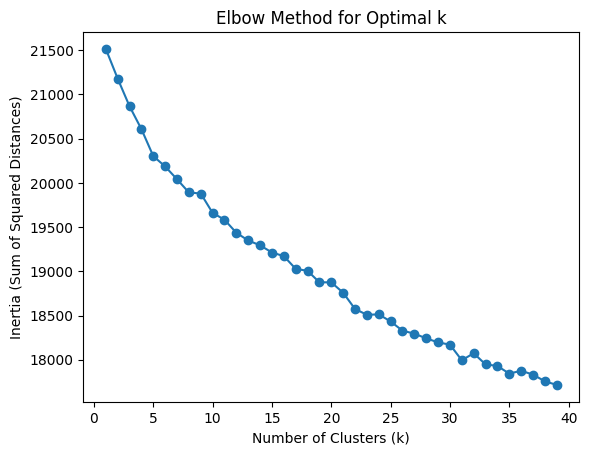

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
recommendation_df_xgb = data[data['industry'] == 'Construction'].sort_values(by='postdate', ascending=True)

# Assuming you have a vectorizer for "payrate"
payrate_vectorizer = TfidfVectorizer()


# Fit the payrate_vectorizer with all payrate values from recommendation_df_xgb
payrate_vectorizer.fit(data['payrate'])


# Transform payrate values from recommendation_df_xgb using the same vectorizer
payrate_transformed = payrate_vectorizer.transform(data['payrate'])
education_transformed = education_vectorizer.transform(data['education'])
skills_transformed = skills_vectorizer.transform(data['skills'])

# Combine payrate, education, and skills features into a single feature matrix
combined_features = hstack([payrate_transformed, education_transformed, skills_transformed])

# Assuming you have a vectorizer for "jobtitle"
jobtitle_vectorizer = TfidfVectorizer()

# Fit the jobtitle_vectorizer with all jobtitle values from data
jobtitle_vectorizer.fit(data['jobtitle'])

# Transform jobtitle values using the same vectorizer
jobtitle_transformed = jobtitle_vectorizer.transform(data['jobtitle'])

label_encoder = LabelEncoder()
jobtitle_encoded = label_encoder.fit_transform(data['jobtitle'])

range_k = range(1,40)
inertia = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(jobtitle_transformed)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(range_k, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.show()

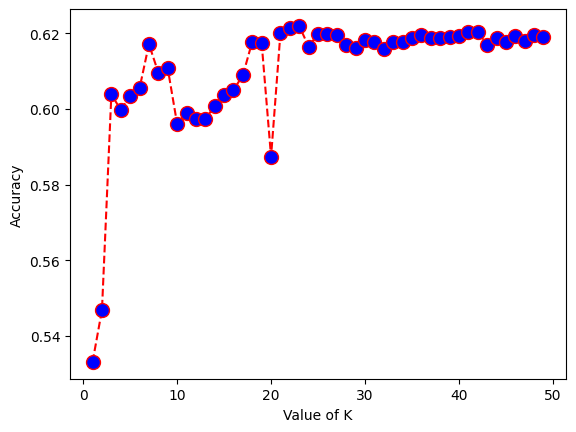

Highest Accuracy: 0.62 (for k = 23)
Accuracy KNN: 0.6219679633867277
KNN model saved as knn_model.pkl


In [17]:
# Apply K-Means clustering on the jobtitle variable
#7-0.42,9-0.42,10-0.38,11-0.44,12-0.39
#overall: 4,70, 5-60+
num_clusters = 5 # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['jobtitle_cluster'] = kmeans.fit_predict(jobtitle_transformed)

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, data['jobtitle_cluster'], test_size=0.2, random_state=42
)
from sklearn import metrics
range_k = range(1,50)
scores = {}
scores_list = []
for k in range_k:
   classifier = KNeighborsClassifier(n_neighbors=k, weights='uniform',metric='minkowski', p=2)
   classifier.fit(X_train, y_train)
   y_pred = classifier.predict(X_test)
   scores[k] = metrics.accuracy_score(y_test,y_pred)
   scores_list.append(metrics.accuracy_score(y_test,y_pred))

# plot a graph (k values vs. accuracy rate)
import matplotlib.pyplot as plt
plt.plot(range_k,scores_list,color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")
plt.show()
best_k = max(scores, key=scores.get)
highest_accuracy = scores[best_k]
print(f"Highest Accuracy: {highest_accuracy:.2f} (for k = {best_k})")

# highest at k=22 for cluster =5
# Create and fit the KNN model
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy KNN:", accuracy_knn)


filename = 'knn_model.pkl'
joblib.dump(knn_model, filename)
print(f"KNN model saved as {filename}")

C:\Users\weiji\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


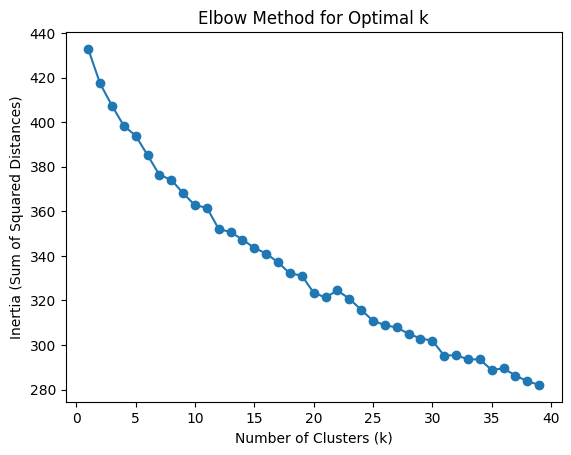

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
recommendation_df_xgb = data[data['industry'] == 'Construction'].sort_values(by='postdate', ascending=True)

# Assuming you have a vectorizer for "payrate"
payrate_vectorizer = TfidfVectorizer()


# Fit the payrate_vectorizer with all payrate values from recommendation_df_xgb
payrate_vectorizer.fit(recommendation_df_xgb['payrate'])


# Transform payrate values from recommendation_df_xgb using the same vectorizer
payrate_transformed = payrate_vectorizer.transform(recommendation_df_xgb['payrate'])
education_transformed = education_vectorizer.transform(recommendation_df_xgb['education'])
skills_transformed = skills_vectorizer.transform(recommendation_df_xgb['skills'])

# Combine payrate, education, and skills features into a single feature matrix
combined_features = hstack([payrate_transformed, education_transformed, skills_transformed])

# Assuming you have a vectorizer for "jobtitle"
jobtitle_vectorizer = TfidfVectorizer()

# Fit the jobtitle_vectorizer with all jobtitle values from data
jobtitle_vectorizer.fit(recommendation_df_xgb['jobtitle'])

# Transform jobtitle values using the same vectorizer
jobtitle_transformed = jobtitle_vectorizer.transform(recommendation_df_xgb['jobtitle'])

label_encoder = LabelEncoder()
jobtitle_encoded = label_encoder.fit_transform(recommendation_df_xgb['jobtitle'])

range_k = range(1,40)
inertia = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(jobtitle_transformed)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(range_k, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.show()

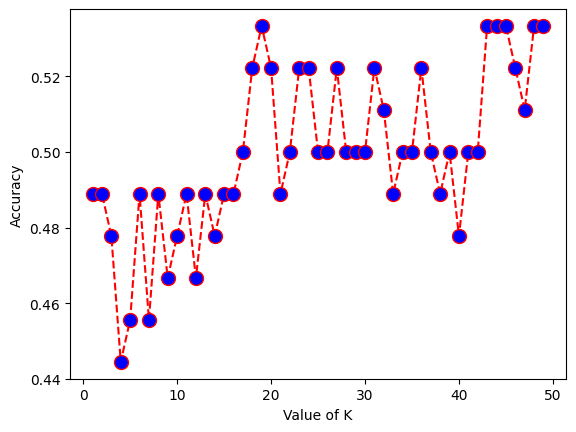

Highest Accuracy: 0.53 (for k = 19)
Accuracy KNN: 0.5333333333333333


In [13]:
# Apply K-Means clustering on the jobtitle variable
#7-0.42,9-0.42,10-0.38,11-0.44,12-0.39
#overall: 4,70, 5-60+
num_clusters = 4 # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
recommendation_df_xgb['jobtitle_cluster'] = kmeans.fit_predict(jobtitle_transformed)

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, recommendation_df_xgb['jobtitle_cluster'], test_size=0.2, random_state=42
)
from sklearn import metrics
range_k = range(1,50)
scores = {}
scores_list = []
for k in range_k:
   classifier = KNeighborsClassifier(n_neighbors=k, weights='uniform',metric='minkowski', p=2)
   classifier.fit(X_train, y_train)
   y_pred = classifier.predict(X_test)
   scores[k] = metrics.accuracy_score(y_test,y_pred)
   scores_list.append(metrics.accuracy_score(y_test,y_pred))

# plot a graph (k values vs. accuracy rate)
import matplotlib.pyplot as plt
plt.plot(range_k,scores_list,color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")
plt.show()
best_k = max(scores, key=scores.get)
highest_accuracy = scores[best_k]
print(f"Highest Accuracy: {highest_accuracy:.2f} (for k = {best_k})")

# highest at k=22 for cluster =5
# Create and fit the KNN model
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy KNN:", accuracy_knn)


In [19]:
app = Flask(__name__, static_folder='assets')  # Initialize the flask App

@app.route('/')  # Homepage
def home():
    jobs_data = {
        'industry': data['industry'],
        'company': data['company'],
        'joblocation_address': data['joblocation_address'],
        'skills': data['skills'],
        'payrate': data['payrate']
    }
    return render_template('job-list.html', jobs=jobs_data)

@app.route('/filter', methods=['POST'])
def filter():
    search = request.form.get('job-type')
    type = request.form.get('job-filter')
    if type == 'Location':
        filtered_data = data[data['joblocation_address'] == search]
    elif type == 'Salary':
        filtered_data = data[data['payrate'] == search]
    else:
        filtered_data = data[data['skills'] == search]
    filtered_data = filtered_data.reset_index(drop=True)
    jobs_data = {
        'industry': filtered_data['industry'],
        'company': filtered_data['company'],
        'joblocation_address': filtered_data['joblocation_address'],
        'skills': filtered_data['skills'],
        'payrate': filtered_data['payrate']
    }
    print(jobs_data['industry'].size)
    print(jobs_data['industry'])
    return render_template('job-list.html', jobs=jobs_data)


@app.route('/search')
def search():
    educations = data['education'].unique()
    payrate = data['payrate'].unique()
    return render_template('job-entry.html', educations=educations,  payrate=payrate)


@app.route('/predict', methods=['POST'])
def predict():
    education = request.form['education']
    jobdescription = request.form['description']
    skills = request.form['skills']
    predicted_industry = predictNew(
        jobdescription=jobdescription,
        education=education,  
        skills=skills, 
        preprocessor=preprocess,
        model=loaded_model,
        education_vectorizer=education_vectorizer,
        skills_vectorizer=skills_vectorizer
    )
    # Filter recommendations based on the predicted industry using XGBoost
    recommendation_df_xgb = data[data['industry'] == predicted_industry].sort_values(by='postdate', ascending=True)
    print(recommendation_df_xgb.info())
    # Assuming you have a vectorizer for "payrate"
    payrate_vectorizer = TfidfVectorizer()
    

    # Fit the payrate_vectorizer with all payrate values from recommendation_df_xgb
    payrate_vectorizer.fit(data['payrate'])
    
    # Get user input for payrate
    payrate = request.form['payrate']
    payrate_fitted = payrate_vectorizer.transform([payrate])
    education_fitted = education_vectorizer.transform([education])
    skills_fitted = skills_vectorizer.transform([skills])
    combined_predictor = hstack([payrate_fitted,education_fitted,skills_fitted])
    
    # Use the KNN model to predict the most suitable cluster label
    knn_loaded_model = joblib.load('./knn_model.pkl')
    predicted_job_titles_encoded = knn_loaded_model.predict(combined_predictor)
    
    # Now 'predicted_job_titles_encoded' contains the cluster labels
    print(predicted_job_titles_encoded)
    
    # Filter the recommended job titles based on KNN prediction
    recommended_job_titles = recommendation_df_xgb[recommendation_df_xgb['jobtitle_cluster'] == predicted_job_titles_encoded[0]]

    return render_template('job-des.html', recommendations=recommended_job_titles)

if __name__ == "__main__":
    app.run(host='127.0.0.1', port=5000, debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [25/Jan/2024 16:22:55] "GET /search HTTP/1.1" 200 -
127.0.0.1 - - [25/Jan/2024 16:22:55] "GET /assets/vendor/animate.css/animate.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:22:55] "GET /assets/vendor/aos/aos.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:22:55] "GET /assets/vendor/bootstrap/css/bootstrap.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:22:55] "GET /assets/vendor/bootstrap-icons/bootstrap-icons.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:22:55] "GET /assets/vendor/boxicons/css/boxicons.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:22:55] "GET /assets/vendor/glightbox/css/glightbox.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:22:55] "GET /assets/vendor/swiper/swiper-bundle.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:22:56] "GET /assets/css/style.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:22:56] "GET /assets/vendor/aos/aos.js HTTP/1.1" 304 -
127

<class 'pandas.core.frame.DataFrame'>
Index: 449 entries, 4895 to 21331
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              449 non-null    object 
 1   education            449 non-null    object 
 2   industry             449 non-null    object 
 3   jobdescription       449 non-null    object 
 4   joblocation_address  449 non-null    object 
 5   jobtitle             449 non-null    object 
 6   payrate              449 non-null    object 
 7   postdate             449 non-null    object 
 8   skills               449 non-null    object 
 9   experience_lower     449 non-null    int64  
 10  experience_upper     449 non-null    int64  
 11  job_age              449 non-null    float64
 12  jobtitle_cluster     449 non-null    int32  
dtypes: float64(1), int32(1), int64(2), object(9)
memory usage: 47.4+ KB
None
[0]


127.0.0.1 - - [25/Jan/2024 16:23:00] "GET /assets/vendor/animate.css/animate.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:01] "GET /assets/vendor/aos/aos.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:01] "GET /assets/vendor/bootstrap/css/bootstrap.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:01] "GET /assets/vendor/bootstrap-icons/bootstrap-icons.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:01] "GET /assets/vendor/boxicons/css/boxicons.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:01] "GET /assets/vendor/glightbox/css/glightbox.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:01] "GET /assets/vendor/swiper/swiper-bundle.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:01] "GET /assets/css/style.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:01] "GET /assets/vendor/aos/aos.js HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:01] "GET /assets/vendor/bootstrap/js/bootstrap.bundle.min.js HTTP/1.1" 304 -
127.0.0.1 - - [2

<class 'pandas.core.frame.DataFrame'>
Index: 449 entries, 4895 to 21331
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              449 non-null    object 
 1   education            449 non-null    object 
 2   industry             449 non-null    object 
 3   jobdescription       449 non-null    object 
 4   joblocation_address  449 non-null    object 
 5   jobtitle             449 non-null    object 
 6   payrate              449 non-null    object 
 7   postdate             449 non-null    object 
 8   skills               449 non-null    object 
 9   experience_lower     449 non-null    int64  
 10  experience_upper     449 non-null    int64  
 11  job_age              449 non-null    float64
 12  jobtitle_cluster     449 non-null    int32  
dtypes: float64(1), int32(1), int64(2), object(9)
memory usage: 47.4+ KB
None
[0]


127.0.0.1 - - [25/Jan/2024 16:23:17] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [25/Jan/2024 16:23:17] "GET /assets/vendor/animate.css/animate.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:17] "GET /assets/vendor/aos/aos.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:17] "GET /assets/vendor/bootstrap/css/bootstrap.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:17] "GET /assets/vendor/boxicons/css/boxicons.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:17] "GET /assets/vendor/bootstrap-icons/bootstrap-icons.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:17] "GET /assets/vendor/glightbox/css/glightbox.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:17] "GET /assets/vendor/swiper/swiper-bundle.min.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:17] "GET /assets/css/style.css HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:17] "GET /assets/vendor/aos/aos.js HTTP/1.1" 304 -
127.0.0.1 - - [25/Jan/2024 16:23:17] "GET /assets/vendor/b